
# Color Quantization using K-Means and GMM

This demo is modified from the code by Layton etal
http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

It performs a pixel-wise Vector Quantization (VQ) of an image, reducing the number of colors required to show the image to n_colors (=16).

In this example, each pixel has a feature vector containing 3 color components (RGB) and a clustering method is used on a subset of pixels in the image to find n_color clusters.  In the image processing literature, the codebook containing all cluster centers is called the color palette. Then the colors of all pixels are replaced by one of the colors in the color palatte.

We compare the K-means method and the GMM method for  clustering. For comparison, a quantized image using a random codebook (colors picked up randomly) is also shown.


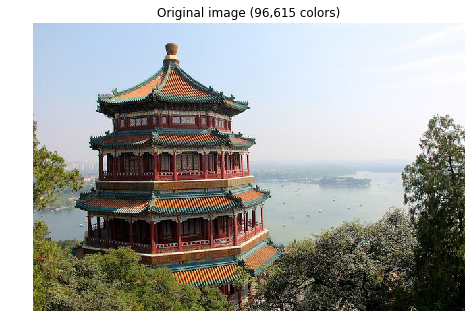

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from sklearn.mixture import GaussianMixture

n_colors = 16

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)
plt.show()

In [2]:
# This function replaces each pixel by its predicted pixel (the cluster mean of the cluster that this pixel belongs to)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image



In [3]:
# Preprocessing the data for clustering

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

# Take a small subset of the pixels
image_array_sample = shuffle(image_array, random_state=0)[:1000]

Kmeans: Fitting model on a small sub-sample of the data
done in 0.143s.
Kmeans: Predicting color indices on the full image
done in 0.087s.


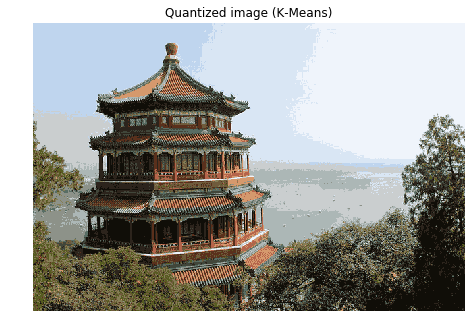

In [4]:
# Clustering using K-means

print("Kmeans: Fitting model on a small sub-sample of the data")
t0 = time()
kmeans = KMeans(n_clusters=n_colors,  init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Kmeans: Predicting color indices on the full image")
t0 = time()
kmeans_labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, kmeans_labels, w, h))
plt.show()

GMM: Fitting model on a small sub-sample of the data
GMM: Fitting done in 0.058s.
GMM: Predicting color indices on the full image (GMM)
done in 0.121s.


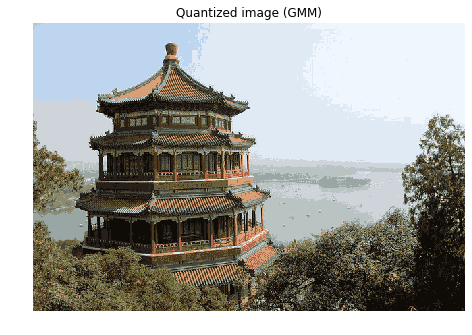

In [5]:
# Clustering using GMM, with K-means results as initial mixture mean

print("GMM: Fitting model on a small sub-sample of the data")
t0 = time()

GMM = GaussianMixture(n_components=n_colors,
                   covariance_type = 'diag', max_iter=100, random_state=0, init_params = 'kmeans')

GMM.fit(image_array_sample)
print("GMM: Fitting done in %0.3fs." % (time() - t0))

# Get labels for all points
print("GMM: Predicting color indices on the full image (GMM)")
t0 = time()
GMM_labels = GMM.predict(image_array)
print("done in %0.3fs." % (time() - t0))



plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (GMM)')
plt.imshow(recreate_image(GMM.means_, GMM_labels, w, h))
plt.show()

Predicting color indices on the full image (random)
done in 0.075s.


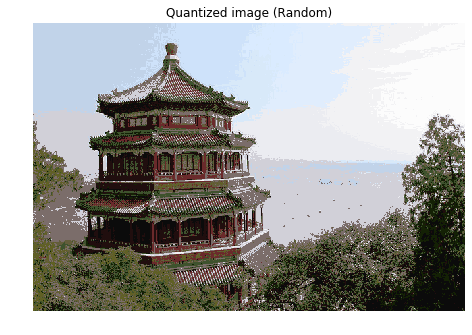

In [6]:
# Using Random Samples as cluster centers, and nearest neighbor to assign clusters

codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


plt.figure(4)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()